In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/Othercomputers/macbook/check3


Mounted at /content/drive
/content/drive/Othercomputers/macbook/check3


In [ ]:
import os
import shutil
import zipfile
from google.colab import files

def download_directory(source_path):
    """
    Download an entire directory from Google Colab to local machine

    Args:
    source_path (str): Full path to the directory you want to download

    Returns:
    None: Creates a zip file and triggers download
    """
    # Ensure the source path exists
    if not os.path.exists(source_path):
        print(f"Error: Directory {source_path} does not exist.")
        return

    # Create a zip filename based on the directory name
    dir_name = os.path.basename(source_path.rstrip('/'))
    zip_filename = f"{dir_name}_download.zip"

    # Create a zip file of the entire directory
    shutil.make_archive(dir_name, 'zip', source_path)

    # Rename the zip file if needed
    if os.path.exists(f"{dir_name}.zip"):
        os.rename(f"{dir_name}.zip", zip_filename)

    # Trigger file download
    files.download(zip_filename)

    # Optional: Clean up the zip file after download
    os.remove(zip_filename)

# Example usage
# download_directory('/content/my_directory')

download_directory('/content/drive/Othercomputers/macbook/check3/data')

In [2]:
# prompt: pip install huggingface transformers

!pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -q "transformers>=4.22.0" # comment in when version is released
!pip install -q datasets sentencepiece tensorboard
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is alread

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
%%bash
# clone repository
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
# copy data


Cloning into 'ICDAR-2019-SROIE'...
Updating files: 100% (1980/1980), done.


In [5]:
%%bash

rm -rf data/

cp -r ICDAR-2019-SROIE/data ./
# clean up
rm -rf ICDAR-2019-SROIE
rm -rf data/box

In [ ]:
import os
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []
print('image path', image_path)
print('metadata path', metadata_path)

image path data/img
metadata path data/key


In [ ]:


# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file

# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
# shutil.rmtree(metadata_path)

In [ ]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")

# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/627 [00:00<?, ?it/s]

Dataset has 626 images
Dataset features are: dict_keys(['image', 'text'])


Random sample is 209
OCR text is {"company": "ELITETRAX MARKETING SDN BHD", "date": "11.02.18", "address": "LOT 1F-01&02,1ST FLR,PARADIGM MALL, NO. 1 JALAN SS 7/26A, KELANA JAYA, 47301 PETALING JAYA", "total": "60.00"}


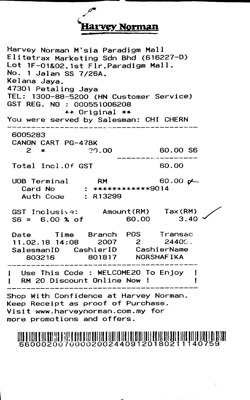

In [ ]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))
#     OCR text is {"company": "LIM SENG THO HARDWARE TRADING", "date": "29/12/2017", "address": "NO 7, SIMPANG OFF BATU VILLAGE, JALAN IPOH BATU 5, 51200 KUALA LUMPUR MALAYSIA", "total": "6.00"}

In [ ]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")
#    Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
#    New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']

NameError: name 'dataset' is not defined